Import des bibli

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurations visuelles
plt.style.use('ggplot')
sns.set_theme()


Chargement des datasets

In [7]:
players_df = pd.read_csv("game_players_stats.csv")
events_df = pd.read_csv("game_events.csv")
meta_df = pd.read_csv("game_metadata.csv")


Test des premières lignes

In [8]:
# Affiche les premières lignes
print("Players:")
print(players_df.head(), '\n')

print("Events:")
print(events_df.head(), '\n')

print("Metadata:")
print(meta_df.head(), '\n')


Players:
   game_id  player_id player_name  team_id               team_name  \
0       15          0      shanji        0    Legend Esport Gaming   
1       15          1       Demon        1  Bilibili Gaming Junior   
2       15          2     yanxuan        0    Legend Esport Gaming   
3       15          3        Viod        0    Legend Esport Gaming   
4       15          4     HanXuan        1  Bilibili Gaming Junior   

  team_acronym     role    win  game_length champion_name  ...  \
0          LEG      Top  False         1415        Irelia  ...   
1         BLGJ      Top   True         1415      Vladimir  ...   
2          LEG      Bot  False         1415        Kai'Sa  ...   
3          LEG  Support  False         1415           Lux  ...   
4         BLGJ      Mid   True         1415        Aatrox  ...   

   player_assists  total_minions_killed  gold_earned  level  \
0               1                   179         8530     12   
1               6                   174        

Verification de la qualité des données

In [9]:
# Dimensions et types
for name, df in zip(['Players', 'Events', 'Metadata'], [players_df, events_df, meta_df]):
    print(f"{name} shape: {df.shape}")
    print(df.dtypes, '\n')

# Valeurs manquantes
print("Missing values (Players):")
print(players_df.isnull().sum())

print("\nMissing values (Events):")
print(events_df.isnull().sum())

print("\nMissing values (Metadata):")
print(meta_df.isnull().sum())


Players shape: (374554, 28)
game_id                             int64
player_id                           int64
player_name                        object
team_id                             int64
team_name                          object
team_acronym                       object
role                               object
win                                  bool
game_length                         int64
champion_name                      object
team_kills                          int64
tower_kills                         int64
inhibitor_kills                     int64
dragon_kills                        int64
herald_kills                        int64
baron_kills                         int64
player_kills                        int64
player_deaths                       int64
player_assists                      int64
total_minions_killed                int64
gold_earned                         int64
level                               int64
total_damage_dealt                  int64
total_

Je pense qu'on peut totalement supprimé la colonne "team acronym" pcq en soit du moment qu'on connnait le nom de l'équipe entière ca sert à rien qu'on essayer de faire de la complétion sur un acronyme.
Sur le reste il va falloir analyser comment on fait pour le "killer_id" et "killed_id" dans la partie "event" pcq ce sont clairement des données intéressantes donc je ne sais pas comment on va pouvoir faire pour les traiter de la bonne façon.
Attention à "drake_type" aussi, je ne sais pas encore ce que c'est, à voir si c'est intéressant.  
APRES discussion : le dragon est quand mm intéressant à savoir étant donné qu'il donne des avantage mais on va juste le transforer en "true" "false"


In [10]:
total_rows = events_df.shape[0]
missing_killer_id = events_df['killer_id'].isnull().sum()
missing_killed_id = events_df['killed_id'].isnull().sum()
missing_drake_type = events_df['drake_type'].isnull().sum()

print(f"Total lignes : {total_rows}")
print(f"Données manquantes killer_id : {missing_killer_id}")
print(f"Pourcentage : {missing_killer_id / total_rows * 100:.2f}%")

print(f"Données manquantes killed_id : {missing_killed_id}")
print(f"Pourcentage : {missing_killed_id / total_rows * 100:.2f}%")

print(f"Données manquantes drake_type : {missing_drake_type}")
print(f"Pourcentage : {missing_drake_type / total_rows * 100:.2f}%")


Total lignes : 1884740
Données manquantes killer_id : 137338
Pourcentage : 7.29%
Données manquantes killed_id : 842221
Pourcentage : 44.69%
Données manquantes drake_type : 1715628
Pourcentage : 91.03%


Le killer_id on manque de peu de données 7,3% donc on va pouvoir essayer de les prédire et de les compléter.  
Le killed_id on manque de beaucoup de données 44,7% donc je sais pas comment on peut faire mais ce serait quand même intéressant de l'avoir pour après faire des liens "Joueur A à tué Joueur B" et estimer qui est meilleurs que qui  
drake_type on manque de beaucoup de données

Enfait je viens de réaliser que c'est pas grave de manquer de killer_id ou killed_id pcq tous les events ne sont pas forcément des kills donc c'est pour ça. ;)

ATTENDS : meme raisonemment que pour les kills, tous les event sont pas des dragons, donc normal de pas avoir le type de dragons sur toutes les lignes de event. MAis du coup faut regarder combien d'event sont des dragons et voir combien de fois on a le type des dragons (1884740 - 1715628)si c'est le mm nombre c'est parfait

In [11]:
print(events_df['event_type'].unique())


['player_kill' 'tower_kill' 'drake_kill' 'baron_nashor_kill'
 'inhibitor_kill' 'rift_herald_kill' 'suicide' 'other' 'resurrection'
 'dragon_kill' 'voidgrub_kill']


In [12]:
# Filtrer les events de type "ELITE_MONSTER_KILL"
elite_events = events_df[events_df['event_type'] == 'drake_kill']

# Parmi eux, ceux où le drake_type est non nul
dragon_events = elite_events[elite_events['drake_type'].notnull()]

# Nombre total d'élite kills
total_elite = elite_events.shape[0]

# Nombre de drake_type non nuls
with_drake_type = dragon_events.shape[0]

# Affichage
print(f"Nombre total de drake_kill : {total_elite}")
print(f"Nombre avec drake_type défini     : {with_drake_type}")
print(f"Proportion : {with_drake_type / total_elite * 100:.2f}%")


Nombre total de drake_kill : 169112
Nombre avec drake_type défini     : 169112
Proportion : 100.00%


C'est bon, nous avons un type de drake à chaque event qui contient un drake

In [13]:
# Filtrer les events de type "ELITE_MONSTER_KILL"
kill_events = events_df[events_df['event_type'] == 'player_kill']
suicide_events = events_df[events_df['event_type'] == 'suicide']

# Parmi eux, ceux où le killer est non nul
killer_events = kill_events[kill_events['killer_id'].notnull()]
killed_events = kill_events[kill_events['killed_id'].notnull()]

# Nombre total d'élite kills
total_elite = kill_events.shape[0]
total_suicide = suicide_events.shape[0]

# Nombre de drake_type non nuls
with_killer_type = killer_events.shape[0]
with_killed_type = killed_events.shape[0]

# Affichage
print(f"Nombre total de kill : {total_elite}")
print(f"Nombre de suicide : {total_suicide}")
print(f"Nombre avec killer défini     : {with_killer_type}")
print(f"Proportion : {with_killer_type / total_elite * 100:.2f}%")
print(f"Il manque : {total_elite - with_killer_type} killer")
print(f"Nombre avec killed défini     : {with_killed_type}")
print(f"Proportion : {with_killed_type / total_elite * 100:.2f}%")


Nombre total de kill : 1042510
Nombre de suicide : 13
Nombre avec killer défini     : 1040381
Proportion : 99.80%
Il manque : 2129 killer
Nombre avec killed défini     : 1042505
Proportion : 100.00%


On a le bon nombre de joueur tué mais pas le bon nombre de joueur tueur. Cela peu peut-être s'expliquer du fait qu'un joueur peut mourir par un monstre ?

In [14]:
#Curiosité je voudrais savoir combien on a de game_id
Real_nb = players_df['game_id'].nunique()

print(f"Total de nombre de game : {Real_nb}")

#verif qu'on a bien le même nombre pour metadata et event
meta_nb = meta_df['game_id'].nunique()
events_nb = events_df['game_id'].nunique()

print(f"Total meta : {meta_nb}")
print(f"Total event : {events_nb}")

Total de nombre de game : 37459
Total meta : 37459
Total event : 37417


Il nous manque certains matchs (42 matchs pour être exact) dans "event" c'est peut-être parce que ces matchs ont été très rapide où n'ont rien donnés.  
Je pense qu'on peut les supprimer du dataset global parce que ca ne représente que 0,1 % de tous les matchs donc c'est rien du tout.  
Mais ça peut quand même être intéressant de vite fait les analyser pour savoir s'il s'est passer qqch d'intéressant à en tirer.  

In [15]:
# Tous les game_id dans players_df
all_games = set(players_df['game_id'].unique())

# Tous les game_id dans events_df
event_games = set(events_df['game_id'].unique())

# Ceux qui sont absents
missing_in_events = all_games - event_games
# Convertir en liste d'entiers et trier
missing_ids_sorted = sorted([int(x) for x in missing_in_events])

print(f"Nombre de game_id absents dans events_df : {len(missing_in_events)}")
print(missing_ids_sorted)


Nombre de game_id absents dans events_df : 42
[5753, 5754, 13215, 21066, 21067, 21068, 21069, 21101, 21102, 21103, 21104, 21118, 21119, 21120, 29466, 29467, 29468, 29483, 29484, 29485, 29593, 29594, 29595, 29596, 29608, 29609, 29610, 37324, 37325, 37326, 37339, 37340, 37341, 37342, 37343, 37402, 37403, 37404, 37447, 37448, 37449, 37450]


Maintenant on va les analyser vite fait surtout avec game_metadata pour voir s'ils ont un point commun et donc une explication à pourquoi ils ne sont pas présent dans event.  

In [16]:
# Crée un DataFrame contenant uniquement les matchs sans événements
missing_meta_df = meta_df[meta_df['game_id'].isin(missing_ids_sorted)]
print(missing_meta_df.shape)
missing_meta_df.head()


(42, 9)


,game_id,date,match_id,tournament_id,tournament_name,series_id,series_name,league_id,league_name
5753,5753,2020-09-13 16:04:02.286605,3529,149,Group B,60,European Masters Summer 2020,5,European Masters
5754,5754,2020-09-13 16:54:05.890573,3530,149,Group B,60,European Masters Summer 2020,5,European Masters
13215,13215,2021-09-13 00:52:03.000000,8544,349,Playoffs,138,LCS Proving Grounds Summer 2021,38,LCS Proving Grounds
21066,21066,2022-09-13 16:01:50.403495,14101,505,Playoffs,207,LVP SL Promotion 2023,11,LVP SL
21067,21067,2022-09-13 17:04:59.997188,14101,505,Playoffs,207,LVP SL Promotion 2023,11,LVP SL


On peut déjà voir que il semblerait que tous les matchs non enregistrés soient joué un 13 septembre... mais on va analyser ça un peu mieux.  

In [17]:
# subset_df = missing_meta_df[['game_id', 'date', 'tournament_name', 'series_name', 'league_name']]

# with pd.option_context('display.max_rows', None):
#     print(subset_df.sort_values(by='game_id')) 

Après analyse nous voyons que tous les matchs non enregistré ont été joué le 13 septembre avant 2024 et le 12 septembre en 2024, je n'ai pas plus d'explications sur "pourquoi chaque année à cette date ce n'est pas enregistré ?" mais quoi qu'il en soit on va les supprimé car ils ne sont pas bcp dans le dataset.

In [18]:
#Ici on va mettre en commun players et metadata en fonction du game_id
#Ensuite on supprime les matchs qui ne sont pas dans events dans notre nouveau df
#Attention pour le moment on ne va pas merged event dans notre nouveau df pcq event contient énormément de ligne/game_id
#Ca pourrait créer des milliers de lignes, pas ouf.
#On travaillera + tard avec des infos événementielles par joueurs ou par match.
player_match_df = pd.merge(players_df, meta_df, on='game_id', how='left')

valid_game_ids = events_df['game_id'].unique()
player_match_df = player_match_df[player_match_df['game_id'].isin(valid_game_ids)]
player_match_df.reset_index(drop=True, inplace=True)
player_match_df.head()


,game_id,player_id,player_name,team_id,team_name,team_acronym,role,win,game_length,champion_name,...,largest_killing_spree,largest_multi_kill,date,match_id,tournament_id,tournament_name,series_id,series_name,league_id,league_name
0,15,0,shanji,0,Legend Esport Gaming,LEG,Top,False,1415,Irelia,...,0,1,2019-09-15 06:03:38.000000,4,4,Playoffs,4,LDL Summer 2019,4,LDL
1,15,1,Demon,1,Bilibili Gaming Junior,BLGJ,Top,True,1415,Vladimir,...,2,1,2019-09-15 06:03:38.000000,4,4,Playoffs,4,LDL Summer 2019,4,LDL
2,15,2,yanxuan,0,Legend Esport Gaming,LEG,Bot,False,1415,Kai'Sa,...,0,1,2019-09-15 06:03:38.000000,4,4,Playoffs,4,LDL Summer 2019,4,LDL
3,15,3,Viod,0,Legend Esport Gaming,LEG,Support,False,1415,Lux,...,0,0,2019-09-15 06:03:38.000000,4,4,Playoffs,4,LDL Summer 2019,4,LDL
4,15,4,HanXuan,1,Bilibili Gaming Junior,BLGJ,Mid,True,1415,Aatrox,...,3,2,2019-09-15 06:03:38.000000,4,4,Playoffs,4,LDL Summer 2019,4,LDL


Petite visualisation de départ :

In [19]:
# sns.countplot(data=players_df, x='role', order=players_df['role'].value_counts().index)
# plt.title("Répartition des rôles des joueurs")
# plt.ylabel("Nombre de joueurs")
# plt.xlabel("Rôle")
# plt.show()

# sns.histplot(players_df['player_kills'], kde=True, bins=20)
# plt.title("Distribution des kills par joueur")
# plt.xlabel("Kills")
# plt.ylabel("Nombre de joueurs")
# plt.show()

# sns.boxplot(data=players_df, x='role', y='player_kills')
# plt.title("Répartition kills par rôle")
# plt.ylabel("Kills")
# plt.xlabel("Rôle")
# plt.show()


# sns.boxplot(data=players_df, x='role', y='gold_earned')
# plt.title("Répartition de l'or gagné par rôle")
# plt.ylabel("Gold gagné")
# plt.xlabel("Rôle")
# plt.show()

# numeric_cols = players_df.select_dtypes(include='number')
# plt.figure(figsize=(12, 10))
# sns.heatmap(numeric_cols.corr(), cmap='coolwarm', annot=True, fmt=".2f")
# plt.title("Corrélations entre variables numériques")
# plt.show()



ATTENTION : Je viens de me rappeler que il faut qu'on crée la colonnes KDA pcq c'est une bonne métrique donc je le fais maintenant :

In [20]:
#Analyse le nombre de fois où le joueur n'est pas mort pour le calcul de KDA pour savoir si quand ca arrive 
#Je fais une division par 1 ou si on fais un NaN.
no_death_count = player_match_df[player_match_df['player_deaths'] == 0].shape[0]
one_death_count = player_match_df[player_match_df['player_deaths'] == 1].shape[0]
print(f"Nombre de joueurs avec 0 mort : {no_death_count}")
print(f"Nombre de joueurs avec 1 mort : {one_death_count}")

total_rows = player_match_df.shape[0]
print(f"Proportion : {no_death_count / total_rows * 100:.2f}% des joueurs")
print(f"Proportion : {one_death_count / total_rows * 100:.2f}% des joueurs")



Nombre de joueurs avec 0 mort : 43219
Nombre de joueurs avec 1 mort : 65265
Proportion : 11.55% des joueurs
Proportion : 17.44% des joueurs


Etant donné qu'on a 11% de joueurs qui ne meurents pas c'est assez significatif, on peut pas les nier et faut les "félicité" de pas mourir donc on va faire en sorte que quand leurs mort = 0 on remplace par 0,1 ou qqch comme ça, pour multiplier un peur leur KDA.  
Je ne fais que 0,1 parce que je ne veux pas avoir des données trop extreme dans mon dataset, je vais aussi surement caper le KDA en fonction des val que les connaisseurs de LOL vont me donner.

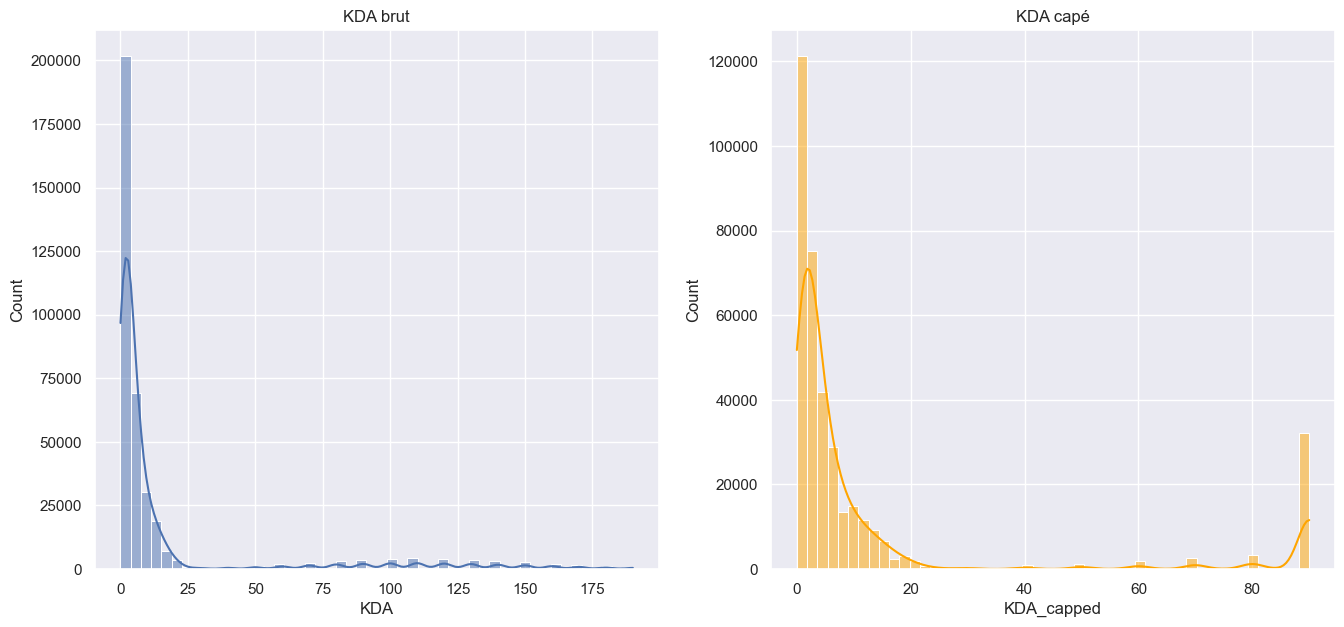

In [21]:
#Création de la colonne KDA 
# Garder le vrai KDA quand c’est défini
player_match_df['KDA'] = (player_match_df['player_kills'] + player_match_df['player_assists']) / player_match_df['player_deaths'].replace(0, 0.1)

#On décide de capper le KDA pcq une valeur de 170 c'est beaucoup trop et ca fausserait nos données d'apprentissage.
#Déjà 50 c'est un KDA hors du commun donc c'est assez représentatif pour dire que c'est exeptionnel
player_match_df['KDA_capped'] = player_match_df['KDA'].clip(upper=90)


plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.histplot(player_match_df[player_match_df['KDA'] < 200]['KDA'], bins=50, kde=True) #Le bin divise la variable KDA en 50 tranches égales 0 < 1er bin < 3,6 < 2eme bin < 7,2 ... -> 180
plt.title("KDA brut")

plt.subplot(1, 2, 2)
sns.histplot(player_match_df[player_match_df['KDA_capped'] < 200]['KDA_capped'], bins=50, kde=True, color='orange') #Le bin divise la variable KDA en 50 tranches égales 0 < 1er bin < 3,6 < 2eme bin < 7,2 ... -> 180
plt.title("KDA capé")
plt.show()



# Features selection

Visualisation des données numériques qui pourraient avoir une corrélation avec la win

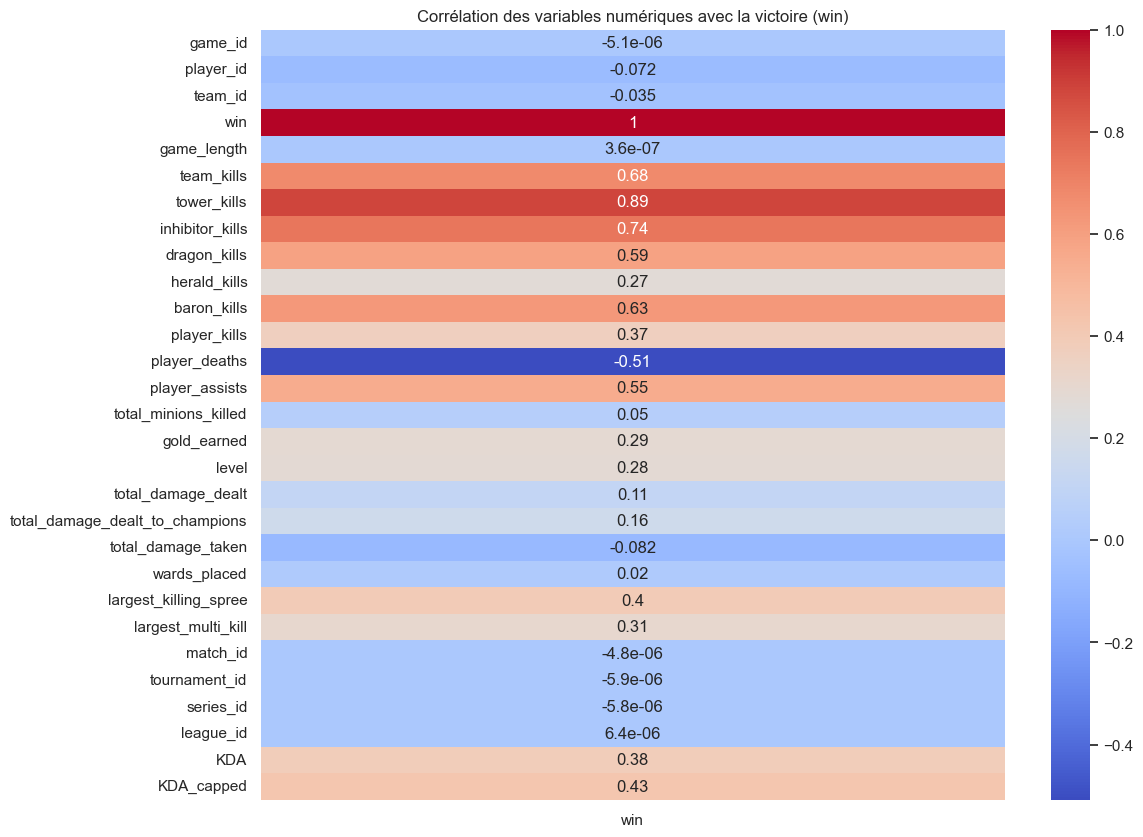

win                                1.000000e+00
tower_kills                        8.880146e-01
inhibitor_kills                    7.449479e-01
team_kills                         6.818135e-01
baron_kills                        6.279086e-01
dragon_kills                       5.904183e-01
player_assists                     5.502283e-01
KDA_capped                         4.278992e-01
largest_killing_spree              3.951092e-01
KDA                                3.843640e-01
player_kills                       3.693435e-01
largest_multi_kill                 3.069631e-01
gold_earned                        2.904191e-01
level                              2.819487e-01
herald_kills                       2.721353e-01
total_damage_dealt_to_champions    1.648171e-01
total_damage_dealt                 1.076241e-01
total_minions_killed               4.955704e-02
wards_placed                       1.989463e-02
league_id                          6.396829e-06
game_length                        3.587

In [22]:
player_match_df['win'] = player_match_df['win'].astype(int)

numeric_cols = player_match_df.select_dtypes(include='number')
corr = numeric_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr[['win']], cmap='coolwarm', annot=True)
plt.title("Corrélation des variables numériques avec la victoire (win)")
plt.show()

print(corr['win'].sort_values(ascending=False))

Okay donc maintenant on peut se dire qu'on va garder que les données > 0,25 (pris arbitrairement) et < -0,25 (pcq elles permettent de prédire des défaites)  
C'est à dire : 
tower_kills  
inhibitor_kills  
team_kills  
baron_kills  
dragon_kills  
player_assists  
largest_killing_spree  
KDA_capped  
KDA  
player_kills  
largest_multi_kill  
gold_earned  
level  
herald_kills  
player_deaths  

In [23]:
# On garde les features corrélées de manière significative
corr_threshold = 0.25
strong_corr_features = corr[abs(corr['win']) > corr_threshold].index.tolist()

# On peut retirer 'win' si elle est incluse
strong_corr_features.remove('win')
print("Features utiles :", strong_corr_features)


Features utiles : ['team_kills', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 'player_kills', 'player_deaths', 'player_assists', 'gold_earned', 'level', 'largest_killing_spree', 'largest_multi_kill', 'KDA', 'KDA_capped']


Je vais essayer d'afficher la fréquence des event ou bien la fréquence d'apparition des joueurs. Dans une logique de "si un joueur n'apparait pas souvent, on peut peut-être le supprimer et ne pas le prendre en compte".

event_type
player_kill          1042510
tower_kill            449292
drake_kill            169112
inhibitor_kill         68934
rift_herald_kill       66798
baron_nashor_kill      51947
voidgrub_kill          35855
other                    252
dragon_kill               26
suicide                   13
resurrection               1
Name: count, dtype: int64


C:\Users\footd\AppData\Local\Temp\ipykernel_3976\2323999134.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis")


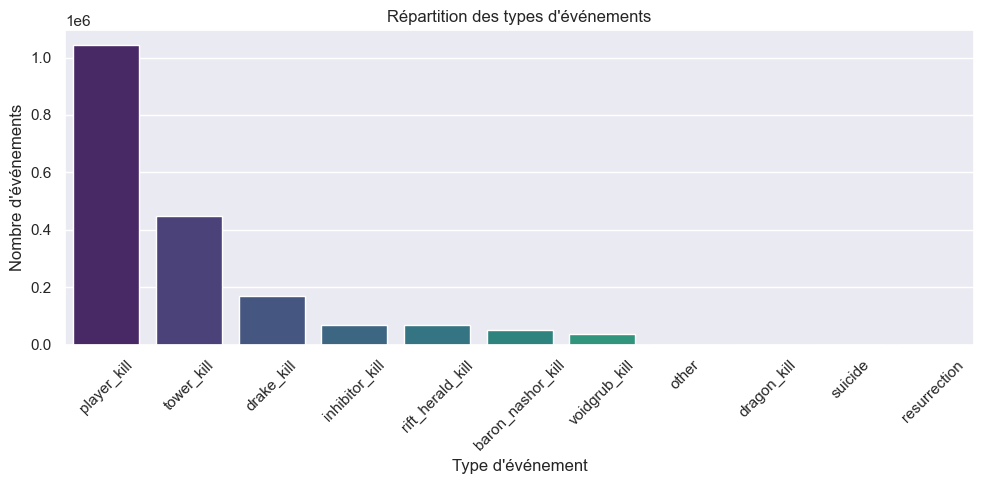

In [24]:
# Fréquence de chaque event :
import matplotlib.pyplot as plt
import seaborn as sns

# Comptage des types d'événements
event_counts = events_df['event_type'].value_counts()
print(event_counts)

# Affichage
plt.figure(figsize=(10, 5))
sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Nombre d'événements")
plt.xlabel("Type d'événement")
plt.title("Répartition des types d'événements")
plt.tight_layout()
plt.show()


In [25]:
#Analyse frq apparitions joueurs
player_counts = player_match_df['player_id'].value_counts()

print(player_counts.describe())



count    4952.000000
mean       75.552100
std       100.790478
min         1.000000
25%        10.000000
50%        31.000000
75%       104.000000
max       705.000000
Name: count, dtype: float64


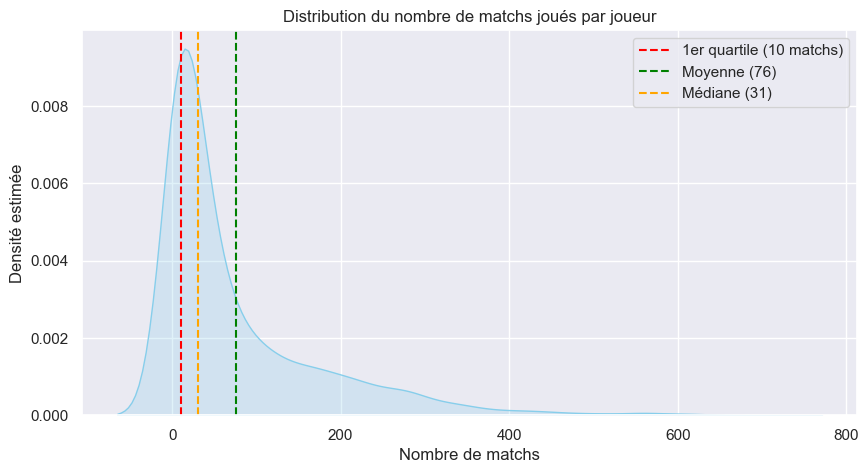

In [26]:
plt.figure(figsize=(10, 5))
sns.kdeplot(player_counts, fill=True, color='skyblue', bw_adjust=1.2)
plt.title("Distribution du nombre de matchs joués par joueur")
plt.xlabel("Nombre de matchs")
plt.ylabel("Densité estimée")
plt.axvline(10, color='red', linestyle='--', label='1er quartile (10 matchs)')
plt.axvline(player_counts.mean(), color='green', linestyle='--', label=f"Moyenne ({player_counts.mean():.0f})")
plt.axvline(player_counts.median(), color='orange', linestyle='--', label=f"Médiane ({player_counts.median():.0f})")
plt.legend()
plt.show()


In [27]:
# Joueurs rares = moins de 10 matchs
rare_players = player_counts[player_counts < 3].index

# Nombre total de joueurs
total_players = player_counts.shape[0]

# Nombre de joueurs rares
rare_player_count = len(rare_players)

# Pourcentage de joueurs rares
rare_player_pct = rare_player_count / total_players * 100

# Nombre de lignes (matchs) concernées
rows_removed = player_match_df[player_match_df['player_id'].isin(rare_players)].shape[0]
total_rows = player_match_df.shape[0]
rows_pct = rows_removed / total_rows * 100

# Affichage
print(f"Nombre total de joueurs : {total_players}")
print(f"Nombre de joueurs avec < 3 matchs : {rare_player_count} ({rare_player_pct:.2f}%)")
print(f"Lignes supprimées (matchs de ces joueurs) : {rows_removed} ({rows_pct:.2f}%)")

Nombre total de joueurs : 4952
Nombre de joueurs avec < 3 matchs : 443 (8.95%)
Lignes supprimées (matchs de ces joueurs) : 737 (0.20%)


Nous faisons le choix de supprimer les joueurs ayant moins de 3 matchs car nous estimons que cela ne nous fournis pas suffisament d'information pour estimer leurs niveau. Et que cela ne nous fais pas perdre trop de données.  
Un coach d'Esport ne prendrait pas le risque d'acheter un joueur qu'il n'a vu jouer que 3 fois...

In [28]:
# 1. Compter le nombre de matchs par joueur
player_counts = player_match_df['player_id'].value_counts()

# 2. Identifier les joueurs "rares" (moins de 3 matchs)
rare_players = player_counts[player_counts < 3].index

# 3. Filtrer player_match_df pour exclure ces joueurs
filtered_df = player_match_df[~player_match_df['player_id'].isin(rare_players)].copy()

# 4. (Optionnel) Réinitialiser l’index
filtered_df.reset_index(drop=True, inplace=True)
player_match_df = filtered_df


# Nettoyage et sélection des colonnes

In [29]:
useful_features = [
    'role', 
    'win',
    'player_kills',
    'player_assists',
    'player_deaths',
    'KDA_capped',
    'tower_kills',
    'inhibitor_kills',
    'team_kills',
    'baron_kills',
    'dragon_kills',
    'largest_killing_spree',
    'largest_multi_kill',
    'gold_earned',
    'level',
    'herald_kills',
    'total_damage_dealt_to_champions'
]


features_df = player_match_df[useful_features].copy()

# Vérification du résultat
print(features_df.shape)
features_df.head()

print(features_df.dtypes)
print(features_df.isnull().sum())
print(features_df['win'].value_counts())
print(features_df['role'].value_counts())
features_df.describe()

(373397, 17)
role                                object
win                                  int64
player_kills                         int64
player_assists                       int64
player_deaths                        int64
KDA_capped                         float64
tower_kills                          int64
inhibitor_kills                      int64
team_kills                           int64
baron_kills                          int64
dragon_kills                         int64
largest_killing_spree                int64
largest_multi_kill                   int64
gold_earned                          int64
level                                int64
herald_kills                         int64
total_damage_dealt_to_champions      int64
dtype: object
role                               0
win                                0
player_kills                       0
player_assists                     0
player_deaths                      0
KDA_capped                         0
tower_kills         

,win,player_kills,player_assists,player_deaths,KDA_capped,tower_kills,inhibitor_kills,team_kills,baron_kills,dragon_kills,largest_killing_spree,largest_multi_kill,gold_earned,level,herald_kills,total_damage_dealt_to_champions
count,373397.000000,373397.000000,373397.000000,373397.000000,373397.000000,373397.000000,373397.000000,373397.000000,373397.00000,373397.000000,373397.000000,373397.000000,373397.000000,373397.000000,373397.000000,373397.000000
mean,0.500679,2.784385,6.397397,2.785692,13.376117,6.024320,0.896402,13.919721,0.69710,2.264402,1.763849,1.060383,11476.335624,14.792749,0.886598,13796.724620
std,0.500000,2.683218,4.446372,1.945851,25.900995,3.617353,1.065473,7.264806,0.74168,1.400718,2.250553,0.833203,3387.416236,2.182823,0.759839,8750.090996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1920.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,3.000000,1.000000,1.333333,3.000000,0.000000,8.000000,0.00000,1.000000,0.000000,1.000000,8917.000000,13.000000,0.000000,7149.000000
50%,1.000000,2.000000,6.000000,3.000000,3.333333,7.000000,1.000000,14.000000,1.00000,2.000000,0.000000,1.000000,11248.000000,15.000000,1.000000,12185.000000
75%,1.000000,4.000000,9.000000,4.000000,9.000000,9.000000,1.000000,19.000000,1.00000,3.000000,3.000000,1.000000,13638.000000,16.000000,1.000000,18348.000000
max,1.000000,28.000000,35.000000,20.000000,90.000000,11.000000,10.000000,79.000000,5.00000,7.000000,22.000000,5.000000,31844.000000,18.000000,3.000000,102344.000000


Notre but maintenant ca va être de transformer role en une variable exploitable.  
Nous allons utiliser du one-hot encoding car cela ne rajoute que 5 colonnes et cela évite que le model interprète un ordre fictif dù à du label encoding (top = 1 jungle = 2,... pourrait faire croire que être Top est meilleur qu'être jungler)

In [ ]:
# One-hot encoding de 'role' (+ supprime la colonne d'origine)
features_encoded = pd.get_dummies(features_df, columns=['role'], prefix='role')
print(features_encoded.dtypes)

win                                  int64
player_kills                         int64
player_assists                       int64
player_deaths                        int64
KDA_capped                         float64
tower_kills                          int64
inhibitor_kills                      int64
team_kills                           int64
baron_kills                          int64
dragon_kills                         int64
largest_killing_spree                int64
largest_multi_kill                   int64
gold_earned                          int64
level                                int64
herald_kills                         int64
total_damage_dealt_to_champions      int64
role_Bot                              bool
role_Jungle                           bool
role_Mid                              bool
role_Support                          bool
role_Top                              bool
dtype: object


D'abord on filtre par rôle puis on normalisera les données (dans le sens inverse ça pause problème pcq role_top/mid/etc sont col binnaire du coup la normalisation les transforme en valeur entre 0,5 ; 1,2 etc donc plus binnaire)

In [47]:
from sklearn.preprocessing import StandardScaler
# 1. Filtrer uniquement les lignes où role == "Top"
features_top = features_df[features_df['role'] == 'Top'].drop(columns='role')

# 2. Séparer X et y
X_top = features_top.drop(columns='win')
y_top = features_top['win']

# 3. Normaliser
scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(X_top)
X_top = pd.DataFrame(X_top_scaled, columns=X_top.columns)


Faut faire ça pour chacun des rôles maintenant

In [ ]:
# 1. Filtrer uniquement les lignes où role == "Jungle"
features_jungle = features_df[features_df['role'] == 'Jungle'].drop(columns='role')

# 2. Séparer X et y
X_jungle = features_jungle.drop(columns='win')
y_jungle = features_jungle['win']

# 3. Normaliser
scaler = StandardScaler()
X_jungle_scaled = scaler.fit_transform(X_jungle)
X_jungle= pd.DataFrame(X_jungle_scaled, columns=X_jungle.columns)

(74699, 15)


In [ ]:
# # Top
# X_top = X_scaled_df[X_scaled_df['role_Top'] == 1].drop(columns=[
#     'role_Top', 'role_Jungle', 'role_Mid', 'role_Bot', 'role_Support'
# ])
# y_top = y[X_scaled_df['role_Top'] == 1]

# # Jungle
# X_jungle = X_scaled_df[X_scaled_df['role_Jungle'] == 1].drop(columns=[
#     'role_Top', 'role_Jungle', 'role_Mid', 'role_Bot', 'role_Support'
# ])
# y_jungle = y[X_scaled_df['role_Jungle'] == 1]

# # Mid
# X_mid = X_scaled_df[X_scaled_df['role_Mid'] == 1].drop(columns=[
#     'role_Top', 'role_Jungle', 'role_Mid', 'role_Bot', 'role_Support'
# ])
# y_mid = y[X_scaled_df['role_Mid'] == 1]

# # Bot
# X_bot = X_scaled_df[X_scaled_df['role_Bot'] == 1].drop(columns=[
#     'role_Top', 'role_Jungle', 'role_Mid', 'role_Bot', 'role_Support'
# ])
# y_bot = y[X_scaled_df['role_Bot'] == 1]

# # Support
# X_support = X_scaled_df[X_scaled_df['role_Support'] == 1].drop(columns=[
#     'role_Top', 'role_Jungle', 'role_Mid', 'role_Bot', 'role_Support'
# ])
# y_support = y[X_scaled_df['role_Support'] == 1]


# Création des modèles :  
Nous allons créer 3 modèles par rôles pour ensuite les comparer et déterminer le quel est le meilleur pour prédire une victoire.  
Nous choisissons comme type de modèles  
Logistic regression pour avoir une base linéaire  
Random Forest pour avoir un non linéaire  
Gradient Boosting pour avoir ...  

Nous allons les comparer sur les critères suivant :  
Accuracy  
f1_score qui est l'équilibre entre la précision et le recall  
roc_auc qui est très utiles pour les modèles binaires

In [49]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

# 💡 Fonction pour tracer la learning curve
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Train accuracy')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation accuracy')
    plt.title(title)
    plt.xlabel("Taille du jeu d'entraînement")
    plt.ylabel("Précision (accuracy)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Fonction pour entrainer les 3 modèles et les comparer

In [50]:
def train_and_compare_models(X, y, role_name='Top'):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(),
        'GradientBoosting': GradientBoostingClassifier()
    }

    results = []

    for name, model in models.items():
        print(f"\n🔧 Entraînement du modèle {name} pour le rôle {role_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        print(f"➡️ Accuracy : {acc:.3f}, F1 : {f1:.3f}, AUC : {auc:.3f}")

        results.append({
            'role': role_name,
            'model': name,
            'accuracy': acc,
            'f1': f1,
            'roc_auc': auc
        })

        # 🔐 Sauvegarder le modèle
        model_filename = f"models/{role_name.lower()}_{name}.pkl"
        joblib.dump(model, model_filename)
        print(f"📦 Modèle sauvegardé sous : {model_filename}")

        # 📉 Tracer la courbe d'apprentissage
        plot_learning_curve(model, X, y, title=f"{name} ({role_name})")

    return pd.DataFrame(results)


Appel de la fonction pour entrainer Top


🔧 Entraînement du modèle LogisticRegression pour le rôle Top
➡️ Accuracy : 0.974, F1 : 0.974, AUC : 0.996
📦 Modèle sauvegardé sous : models/top_LogisticRegression.pkl


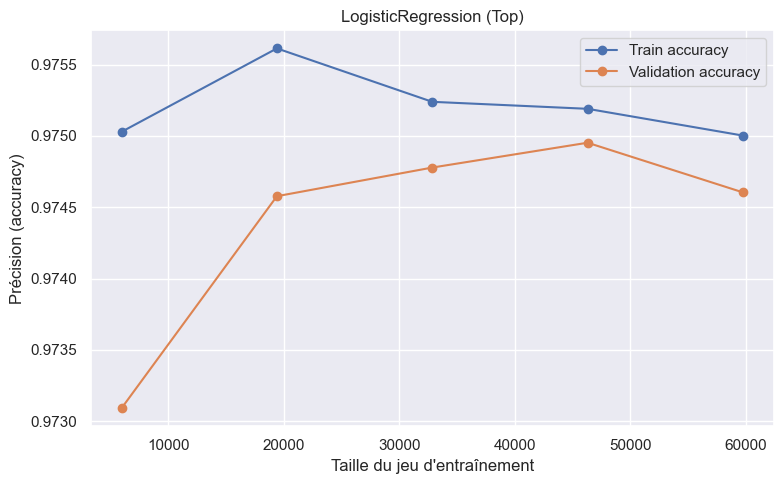


🔧 Entraînement du modèle RandomForest pour le rôle Top
➡️ Accuracy : 0.976, F1 : 0.976, AUC : 0.996
📦 Modèle sauvegardé sous : models/top_RandomForest.pkl


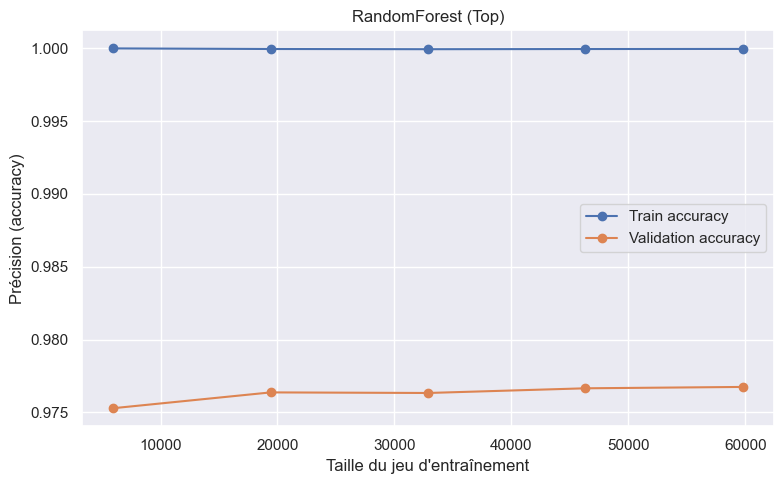


🔧 Entraînement du modèle GradientBoosting pour le rôle Top
➡️ Accuracy : 0.977, F1 : 0.977, AUC : 0.997
📦 Modèle sauvegardé sous : models/top_GradientBoosting.pkl


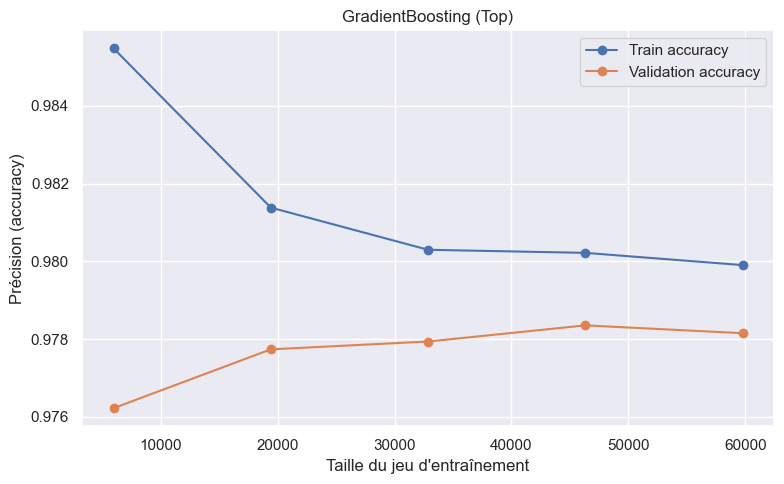

In [51]:
results_top = train_and_compare_models(X_top, y_top, role_name='Top')

Appel de la fonction pour entrainer Jungle

In [36]:
#results_jungle = train_and_compare_models(X_jungle, y_jungle, role_name='Jungle')

Appel de la fonction pour entrainer Mid

In [37]:
#results_mid = train_and_compare_models(X_mid, y_mid, role_name='Mid')

Appel de la fonction pour entrainer Bot

In [38]:
#results_bot = train_and_compare_models(X_bot, y_bot, role_name='Bot')

Appel de la fonction pour entrainer Support

In [39]:
#results_support = train_and_compare_models(X_support, y_support, role_name='Support')